# CO₂ Leakage Estimation — Naïve Monte Carlo (MC) and IS Realization Reconstruction

### Purpose
This notebook reproduces the **first part** of the workflow described in the paper *“Quantifying CO₂ Leakage risk when Planning Safe Geological Carbon Storage using importance sampling of failure probabilities”*.  

It is designed to make the paper’s methodology easier to follow and replicate by implementing all steps **up to the reconstruction of the Importance Sampling (IS) realizations**. At this point, the workflow has generated and reconstructed IS samples (**m′⁽ˡ⁾**) ready for forward simulation and weighting in the second notebook (`Final_Script_after_IS_Simulation.ipynb`).

---

### Workflow Figure
<p align="center">
  <img src="/Users/sofiamantillasalas/Documents/GitHub_Sofia/CCS_structure/Jupyter_scripts_and_functions/Fig_2.png" 
       alt="Workflow for estimating CO₂ leakage probability" width="1150"/>
</p>

**Figure 1. Workflow for estimating CO₂ leakage probability with naïve Monte Carlo (MC) and Importance Sampling (IS).**  
The process begins with generating an initial batch of subsurface model realizations **m⁽ˡ⁾** via naïve MC. Each realization is forward simulated to obtain prediction variables **h⁽ˡ⁾**, from which the running leakage probability **p̂ₙ** and Chebyshev confidence bands are computed. If the desired confidence interval relative to the prescribed safety threshold **p_risk** is not reached, evaluate whether additional naïve MC simulations (**L_add**) are feasible. If not, IS is applied by constructing an alternative distribution **g(m)** that focuses sampling on leakage-prone scenarios (**h₁⁽ˡ⁾ = 1**). IS samples are reweighted to recover unbiased estimates, and the effective sample size (ESS) is tracked in the subsequent stage.

---

### Pipeline Overview
This notebook covers these steps:

| Step | Description                                                                                                                               | Status            |
| ---- | ----------------------------------------------------------------------------------------------------------------------------------------- | ----------------- |
| 1    | Load model inputs sampled by Naïve Monte Carlo (**m₁: top surfaces**, **m₂: porosity**)                                                   | ✅                 |
| 2    | Load failure/no failure outcomes **h₁⁽ˡ⁾** obtained from forward simulations            | ✅                 |
| 3    | Estimate running failure probability and Compute Chebyshev confidence bands                                                                | ✅                 |
| 4    | Estimate Required Number of Simulations Using Chebyshev’s Inequality and check if desired confidence interval relative to the prescribed safety threshold **p_risk** has been reached with the initial set of **L** simulations| ✅                 |
| 5    | Check if Importance Sampling (IS) is necessary                                                                                            | ✅                 |
| 5.1  | Apply PCA on **m₁** and **m₂** to reduce dimensionality                                                                                   | ✅                 |
| 5.2  | Perform DGSA on PCA scores to identify sensitive components                                                                               | ✅                 |
| 5.3  | Fit MKDE (Multivariate Kernel Density Estimation) on sensitive PC scores to construct the IS alternative distribution **g(m)**            | ✅                 |
| 5.4  | Resample new PC scores from IS alternative distribution **g(m)**                                                                          | ✅                 |
| 5.5  | Reconstruct model variables (**m₁′**, **m₂′**) with the resampled PC scores                                                               | ✅                 |
| 6    | Compute IS weights and Effective Sample Size (ESS)                                                                                        | ⏩ *next notebook* |
| 7    | Estimate IS running leakage probability and Chebyshev band using ESS                                                                      | ⏩ *next notebook* |
| 8    | Check if desired confidence interval relative to the prescribed safety threshold **p_risk** has been reached    | ⏩ *next notebook* |


---

### Output Summary
The reconstructed IS realizations (**m′⁽ˡ⁾**) — including surfaces and porosity arrays — are exported as `.npy` and `.mat` files for the next stage:

These outputs will be the **inputs** for the second notebook → `Final_Script_after_IS_Simulation.ipynb`, which performs weighting, ESS computation, and IS leakage probability estimation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.decomposition import PCA
import os
from sklearn.neighbors import KernelDensity
from scipy.stats import beta
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import QuantileTransformer
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import savemat
from pathlib import Path

In [ ]:
!pip install gstools
pip install scikit-fmm

In [ ]:
# Case identifiers (consistent with repo folder names)
CASE = "Inputs_for_Final_Script_after_Naive_Simulation"

# Define input and output paths relative to the repository structure
INPUTS_FOLDER = Path("data") / CASE

print(f"📥 Input folder : {INPUTS_FOLDER.resolve()}")

# --- Notes ---
# Input folder contains the outputs of the initial Naïve Monte Carlo (NMC) stage,
# including MRST CO₂ flow simulation results (h_1).
# This notebook performs PCA, DGSA, and MKDE-based importance sampling setup,
# generating resampled IS realizations that are used in the subsequent IS simulation stage and next notebook..


### Step 1 — Load Naïve Monte Carlo Inputs

In this step, we load all subsurface model inputs generated by **Naïve Monte Carlo (MC)** sampling.  
Each realization represents one possible configuration of the reservoir top surface (**m₁**) and porosity field (**m₂**) used in the forward flow simulations.  
These form the baseline ensemble from which leakage outcomes (**h₁**, **h₂**) were derived.

**Inputs loaded:**
- `surfaces.npy` → Top reservoir surface realizations (**m₁**)  
- `porosity.npy` → Porosity realizations (**m₂**)  
- `CO2height.npy` → Resulting CO₂ saturation maps after flow simulation (**h₂⁽ˡ⁾**)  
- `surf_x_coor.npy`, `surf_y_coor.npy` → Grid coordinates for top surfaces  
- `phi_x_coor.npy`, `phi_y_coor.npy` → Grid coordinates for porosity models  

The dataset is loaded from the folder:

`/Users/sofiamantillasalas/Library/CloudStorage/GoogleDrive-sofiams@stanford.edu/My Drive/Research_Python/Structural_trapping/Jupyter_Python_Research/Outputs_jupyter/final_methods_code_CCS_paper/`

This step defines the model variables **m⁽ˡ⁾ = (m₁⁽ˡ⁾, m₂⁽ˡ⁾)** and the corresponding prediction variable **h₂⁽ˡ⁾**, consistent with the *“4.Geological Carbon Sequestration Problem Set-up”* section of the paper.


In [117]:
m_1 = np.load(INPUTS_POST_SIM_FOLDER +'surfaces.npy') # m_1 top reservoir surfaces sampled with Naive MC
m_2= np.load(INPUTS_POST_SIM_FOLDER +'porosity.npy') # m_2 porosity models sampled with Naive MC
h_2 = np.load(INPUTS_POST_SIM_FOLDER +'CO2height.npy') # h_2 CO2 saturation after flow simulation
m_1_x_coor = np.load(INPUTS_POST_SIM_FOLDER +'surf_x_coor.npy') # x coordinates for top reservoir surfaces
m_1_y_coor = np.load(INPUTS_POST_SIM_FOLDER +'surf_y_coor.npy') # y coordinates for top reservoir surfaces
m_2_x_coor = np.load(INPUTS_POST_SIM_FOLDER +'phi_x_coor.npy') # x coordinates for porosity models
m_2_y_coor = np.load(INPUTS_POST_SIM_FOLDER +'phi_y_coor.npy') # y coordinates for porosity models
print("m_2 shape:", m_1.shape)
print("m_1 shape:", m_2.shape)
print("h_2 shape:", h_2.shape)
n_realizations = m_1.shape[1]
print("Number of Naive MC realizations:", n_realizations)

m_2 shape: (19136, 300)
m_1 shape: (108470, 300)
h_2 shape: (10847, 300)
Number of Naive MC realizations: 300


### Step 2 — Load Failure/No-Failure Outcomes (**h₁⁽ˡ⁾**) and Classify Leakage

In this step, we load the binary failure variable **h₁⁽ˡ⁾**, which indicates whether each realization in the naïve Monte Carlo (MC) ensemble resulted in CO₂ leakage:

- **h₁⁽ˡ⁾ = 1** → the model leaked (failure)  
- **h₁⁽ˡ⁾ = 0** → the model did not leak (safe)

These outcomes were pre-computed during the forward flow simulations, where a realization is labeled as a **failure** if the leaked volume exceeds 0.1 % of the total injected CO₂.  
The loaded files are:

- `h_1_models_leaking.npy` → Binary leakage indicator (**h₁⁽ˡ⁾**) of shape (n_realizations,)  
- `idx_failure_models.npy` → Indices of leaking models (**ℓ where h₁⁽ˡ⁾ = 1**)  
- `sum_h_1_failure.npy` → Total number of leaking realizations (scalar)  

After loading, visualize the proportion of leaking vs. non-leaking cases using a pie chart. This provides a quick diagnostic of the frequency of rare failure events within the naïve MC ensemble.

**Figure:** *Failure models(**h₁ = 1**)– Naïve MC – L simulations*  
The pie chart shows the percentage of models that exceed the 0.1 % leakage threshold (coral) versus those below it (dark cyan).



In [118]:
h_1 = np.load(INPUTS_POST_SIM_FOLDER + 'h_1_models_leaking.npy')  # shape (n_realizations,)
idx_failure_models = np.load(INPUTS_POST_SIM_FOLDER + 'idx_failure_models.npy', allow_pickle=True)  # shape (n_leak_models,)
sum_h_1_failure = np.load(INPUTS_POST_SIM_FOLDER + 'sum_h_1_failure.npy')  # scalar 
print("Number of leaking models from Naive MC:", sum_h_1_failure)


Number of leaking models from Naive MC: 9.0


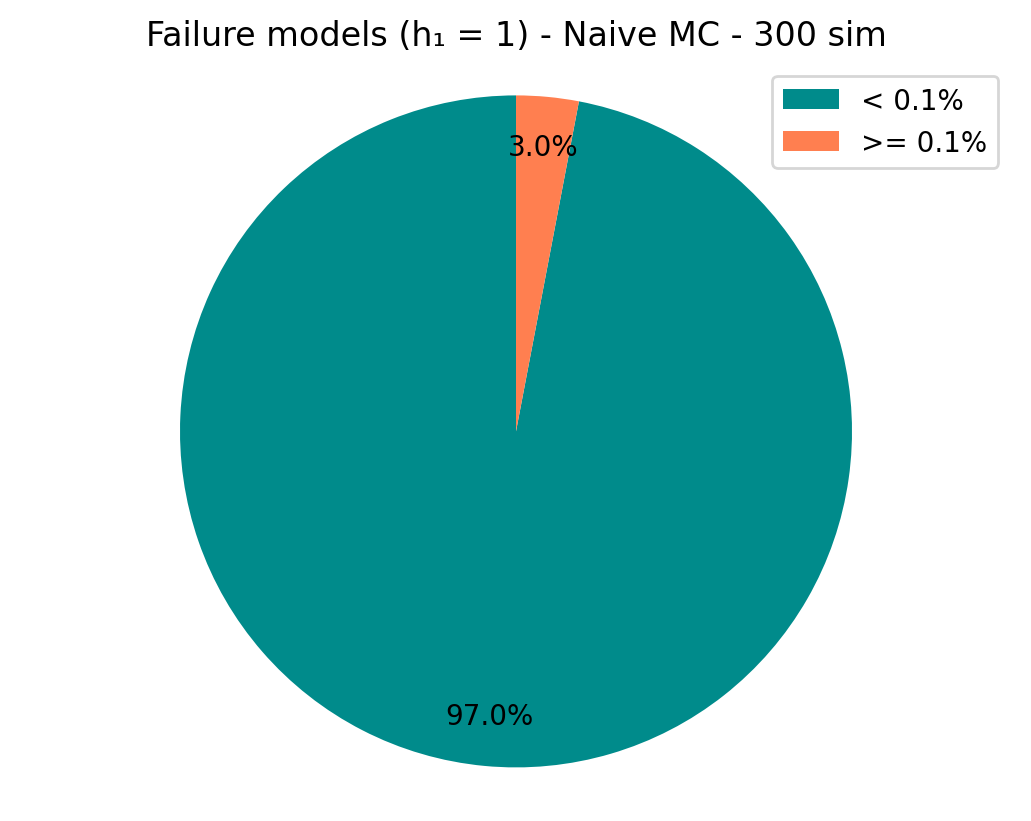

In [119]:
Safety_threshold = ["< 0.1%", ">= 0.1%"]
model_count = [n_realizations - sum_h_1_failure, sum_h_1_failure]

fig, ax = plt.subplots()
wedges, labels, _ = ax.pie(model_count, startangle=90, autopct='%1.1f%%', pctdistance=0.85,colors=['darkcyan', 'coral'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title('Failure models (h₁ = 1) - Naive MC - {} sim'.format(n_realizations))

# Move the labels outside the pie
for label, wedge in zip(labels, wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))
    x_label = x * 1.15
    y_label = y * 1.15
    horizontal_alignment = 'center' if x_label >= 0 else 'right'
    vertical_alignment = 'center' if y_label >= 0 else 'bottom'
    ax.text(x_label, y_label, label.get_text(), ha=horizontal_alignment, va=vertical_alignment)

# Add legend
ax.legend(wedges, Safety_threshold)

# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'pie_chart.png', dpi=300)

plt.show()

### Step 3 — Estimate running failure probability and Compute Chebyshev confidence bands

Since $h_1$ is a binary variable, the underlying probability of that outcome, $p$, is defined as its expectation:

$$
p = E[h] 
$$
To determine how many simulations (**L**) are required for a reliable estimate of the leakage probability $\hat{p}$ or in this case $\hat{p}_{\mathrm{NaiveMC}}$,
we apply Chebyshev’s inequality, which provides a distribution-free confidence bound on the sample mean.
This approach quantifies the uncertainty in the Monte Carlo estimate of the failure probability without assuming normality.

The inequality is expressed as:

$$
P(|\hat{p} - p| \geq \varepsilon p) \leq \delta
$$

where:

* $\varepsilon = 0.33$  → relative error tolerance
* $\delta = 0.05$ → probability that deviation exceeds tolerance (corresponding to 95% confidence)

The safety condition requires that:

$$
(1 + \varepsilon)\,\hat{p}_{\mathrm{NaiveMC}} < p_{\text{risk}} = 0.04
$$

The running mean and variance of $\hat{p}_{\mathrm{NaiveMC}}$ are evaluated sequentially to track the convergence of  $\hat{p}_{\mathrm{NaiveMC}}$, and Chebyshev confidence bands $\hat{p}_{\mathrm{NaiveMC}} \pm \kappa\,\mathrm{SE}$ are plotted, where $\kappa = 1 / \sqrt{\delta}$.

In [187]:
Safety_h_1_prob = 0.04 # target safety probability 4.0%
epsilon = 0.33 # relative error tolerance
delta_tolerance = 0.05 # 95% confidence
k_cheb = 1/np.sqrt(delta_tolerance) # Chebyshev constant
print(f'Safety_h_1_prob = {Safety_h_1_prob}')
print(f'epsilon = {epsilon}')
print(f'delta_tolerance = {delta_tolerance}')
print(f'k_cheb = {k_cheb}')

Safety_h_1_prob = 0.04
epsilon = 0.33
delta_tolerance = 0.05
k_cheb = 4.47213595499958


In [ ]:
def running_stats(x):
    n = len(x)
    idx  = np.arange(1, n+1)
    c1   = np.cumsum(x)
    c2   = np.cumsum(x**2)
    mean = c1/idx
    var  = (c2 - idx*mean**2)/np.maximum(idx-1, 1)
    var[0] = 0.0
    return mean, var

# NMC estimate of failure probability with Chebyshev confidence bands
mean_NMC, var_NMC = running_stats(h_1) # h_1 is binary variable (0,1) sampled with Naive Monte Carlo (NMC)
std_NMC   = np.sqrt(var_NMC) 
i_NMC     = np.arange(1, len(mean_NMC)+1) # iteration index
se_NMC    = std_NMC / np.sqrt(i_NMC) # standard error

### Step 4 - Estimate Required Number of Simulations Using Chebyshev’s Inequality and check if desired confidence interval relative to the prescribed safety threshold **p_risk** has been reached with the initial set of **L** simulations

The minimum number of simulations needed to satisfy this confidence criterion is given by:

$$
L_{\text{Naive}} \geq
\frac{\mathrm{Var}(\hat{p}_{\mathrm{NaiveMC}})}{\delta,\varepsilon^2,(\hat{p}_{\mathrm{NaiveMC}})^2}
$$

**Figure — Running estimate of failure probability ($\hat{p}_{\mathrm{NaiveMC}}$) with Chebyshev confidence bands.**
The green dashed line marks the safety threshold $p_{\text{risk}} = 0.04$, and the blue band shows how uncertainty decreases as the number of simulations increases.

In [201]:
# Total number of simulations required according to Chebyshev inequality
L_minimum_NMC = (var_NMC[-1])/ (delta_tolerance * (epsilon**2) * (mean_NMC[-1]**2))
print(f'L_minimim_NMC >= {L_minimum_NMC:.0f}')
if L_minimum_NMC > n_realizations:
    print(f'Warning ⚠️: The initial number of Naive MC simulations ({n_realizations}) is less than the minimum required number of simulations ({L_minimum_NMC:.0f}) for the desired accuracy and confidence level.')
else:
    print(f'The initial number of Naive MC simulations ({n_realizations}) meets the required minimum number of simulations ({L_minimum_NMC:.0f}) for the desired accuracy and confidence level.') 

L_minimim_NMC >= 5958
Warning ⚠️: The initial number of Naive MC simulations (300) is less than the minimum required number of simulations (5958) for the desired accuracy and confidence level.


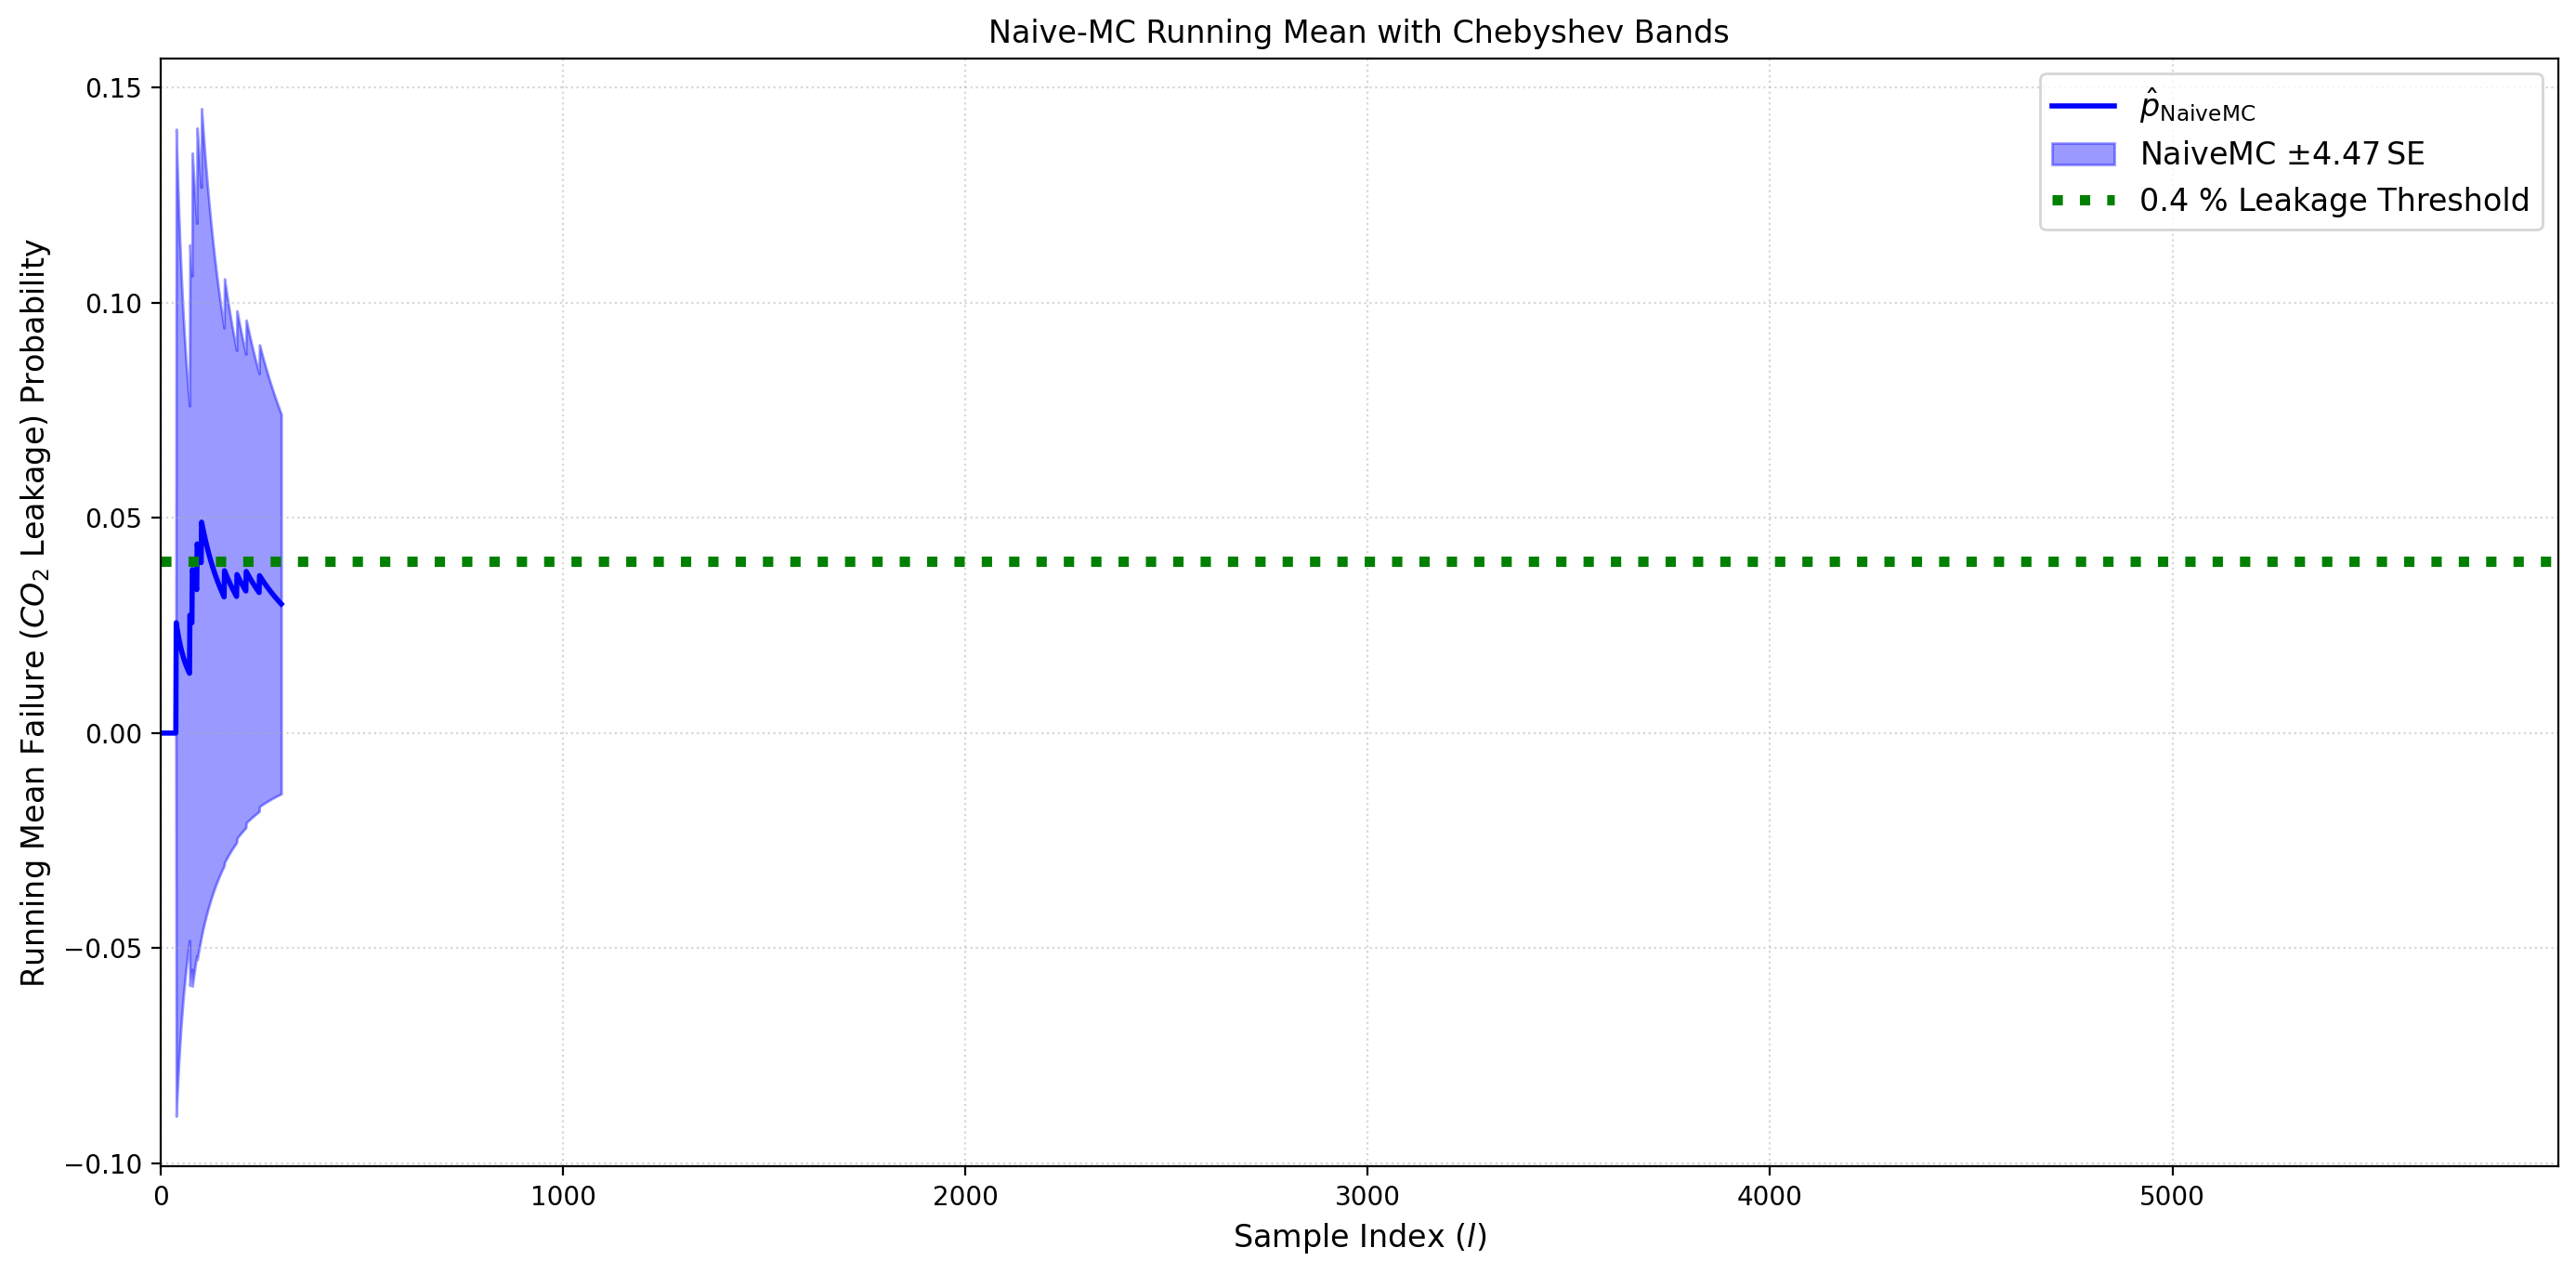

In [197]:
# Plot running estimate of failure probability with Chebyshev confidence bands
plt.figure(figsize=(14, 7))
plt.plot(i_NMC, mean_NMC, color='blue', lw=2, label=r'$\hat{p}_{\mathrm{NaiveMC}}$')
plt.fill_between(i_NMC, mean_NMC - k_cheb*se_NMC, mean_NMC + k_cheb*se_NMC,
                 color='blue', alpha=0.4, label=rf'NaiveMC $\pm {k_cheb:.2f}\,\mathrm{{SE}}$')
plt.axhline(Safety_h_1_prob,    color='green', ls=':', lw=4, label='0.4 % Leakage Threshold') 
plt.legend(loc='upper right', fontsize=12) 
plt.xlim(0, L_minimum_NMC)
plt.xlabel('Sample Index ($l$)', fontsize=12)
plt.ylabel('Running Mean Failure ($CO_2$ Leakage) Probability', fontsize=12)
plt.title('Naive-MC Running Mean with Chebyshev Bands')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

Because only 300 realizations were available in the initial naïve Monte Carlo ensemble, the resulting confidence band remains wide and the estimate of $\hat{p}_{\mathrm{NaiveMC}}$ has not yet converged. In other words, the upper confidence band still exceeds the safety threshold of 0.04, indicating that additional simulations are needed to achieve the desired confidence level.

### Step 5 - Check if Importance Sampling (IS) Is Necessary
This step is to evaluate whether the required confidence level can be achieved by adding more naïve Monte Carlo (MC) simulations,
or if computational constraints make it necessary to switch to Importance Sampling (IS).

If the required number of additional simulations

$$
L_{\text{add}} = L_{\text{minimum}} - L_{\text{initial}}
$$

can be run **within available time and computational resources**,
then the workflow proceeds with additional naïve MC realizations.
Otherwise, **Importance Sampling (IS)** is applied to efficiently target leakage-prone regions of the parameter space.

In [198]:
# --- Inputs ---
L_initial = n_realizations                     # current number of Naive MC realizations
L_minimum = L_minimum_NMC                      # total number required from Chebyshev criterion
L_add = L_minimum - L_initial                  # additional realizations needed

# --- Display summary ---
print(f"Initial number of Naïve MC simulations (L_initial): {L_initial:.0f}")
print(f"Required number for desired confidence (L_minimum): {L_minimum:.0f}")
print(f"Additional simulations needed (L_add): {L_add:.0f}")

# --- Feasibility check ---
# Define a rough upper bound for computational feasibility (user-defined)
L_max_feasible = 1000   # Example threshold — adjust based on computational limits

if L_add <= 0:
    print("✅ Desired confidence already achieved — no additional simulations needed.")
elif L_add <= L_max_feasible:
    print("✅ Feasible to continue with additional Naïve MC simulations.")
else:
    print("⚠️  Importance Sampling (IS) required — additional Naïve MC simulations exceed feasible limit.")

Initial number of Naïve MC simulations (L_initial): 300
Required number for desired confidence (L_minimum): 5958
Additional simulations needed (L_add): 5658
⚠️  Importance Sampling (IS) required — additional Naïve MC simulations exceed feasible limit.


### Step 5.1 — Importance Sampling: PCA of High-Dimensional $m_1$ and $m_2$

To construct the proposal distribution $g(m)$ required for Importance Sampling (IS), we first identify which combinations of model variables $m_1^{(l)}$ (top-surface geometry) and $m_2^{(l)}$ (porosity) lead to leakage outcomes $h_1^{(l)}=1$.
Because the uncertainty in $h$ stems from the uncertainty in $m$, the goal is to focus future sampling on model combinations more likely to produce leakage events, thereby reaching the Chebyshev confidence criterion with far fewer forward simulations.

However, both $m_1$, $m_2$, and the CO₂-saturation field $h_2$ are **high-dimensional**.
Before performing the distance-based Global Sensitivity Analysis (DGSA), we apply **Principal Component Analysis (PCA)** to reduce dimensionality while retaining nearly all variability of the data.

**Workflow summary:**

1. **Dimensionality reduction:**
   Perform PCA separately on $m_1$, $m_2$, and $h_2$ to obtain principal-component (PC) score vectors that capture ≈ 99 % of the total variance.
2. **Sensitivity identification:**
   Use these PC scores in the DGSA to determine which components most strongly influence leakage responses $h_1^{(l)}$ and $h_2^{(l)}$.
   (Including $h_2$ provides spatial information about plume migration.)
3. **Target-distribution construction:**
   Fit a multivariate Kernel Density Estimate (KDE) to the top seven leakage-sensitive PC score vectors.
   This KDE defines the alternative sampling distribution $g(m)$ for the IS procedure.

---

✅ **Notes:**

* The same procedure is repeated for $m_2$ (porosity) and $h_2$ (CO₂ saturation).
* The saved scree plot helps verify the dimensionality cutoff before continuing with the DGSA.


In [215]:
# Principal component analysis (PCA) - surface m1
# load and transpose the data
data = np.transpose(m_1)
# PCA
pca = PCA()
pcs = pca.fit_transform(data)
m_1_score = pcs[:, :n_realizations]  # Extract the scores for the first nmodels
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
# Save the scores
np.save(OUTPUTS_FOLDER + 'm_1score_' + case_name + '.npy', m_1_score)

In [216]:
# find how many PCs to use in DGSA
threshold = 0.97 # 99% explained variance
cumulative_sum = 0.0
x_m_1 = 0 # number of PC scores that represent 99% variance.
while cumulative_sum < threshold:
    cumulative_sum += explained[x_m_1]
    x_m_1 += 1
print("x_m_1:", x_m_1)
PC_m1_labels = [f"PC{i}-m1" for i in range(1, x_m_1+1)]

x_m_1: 7


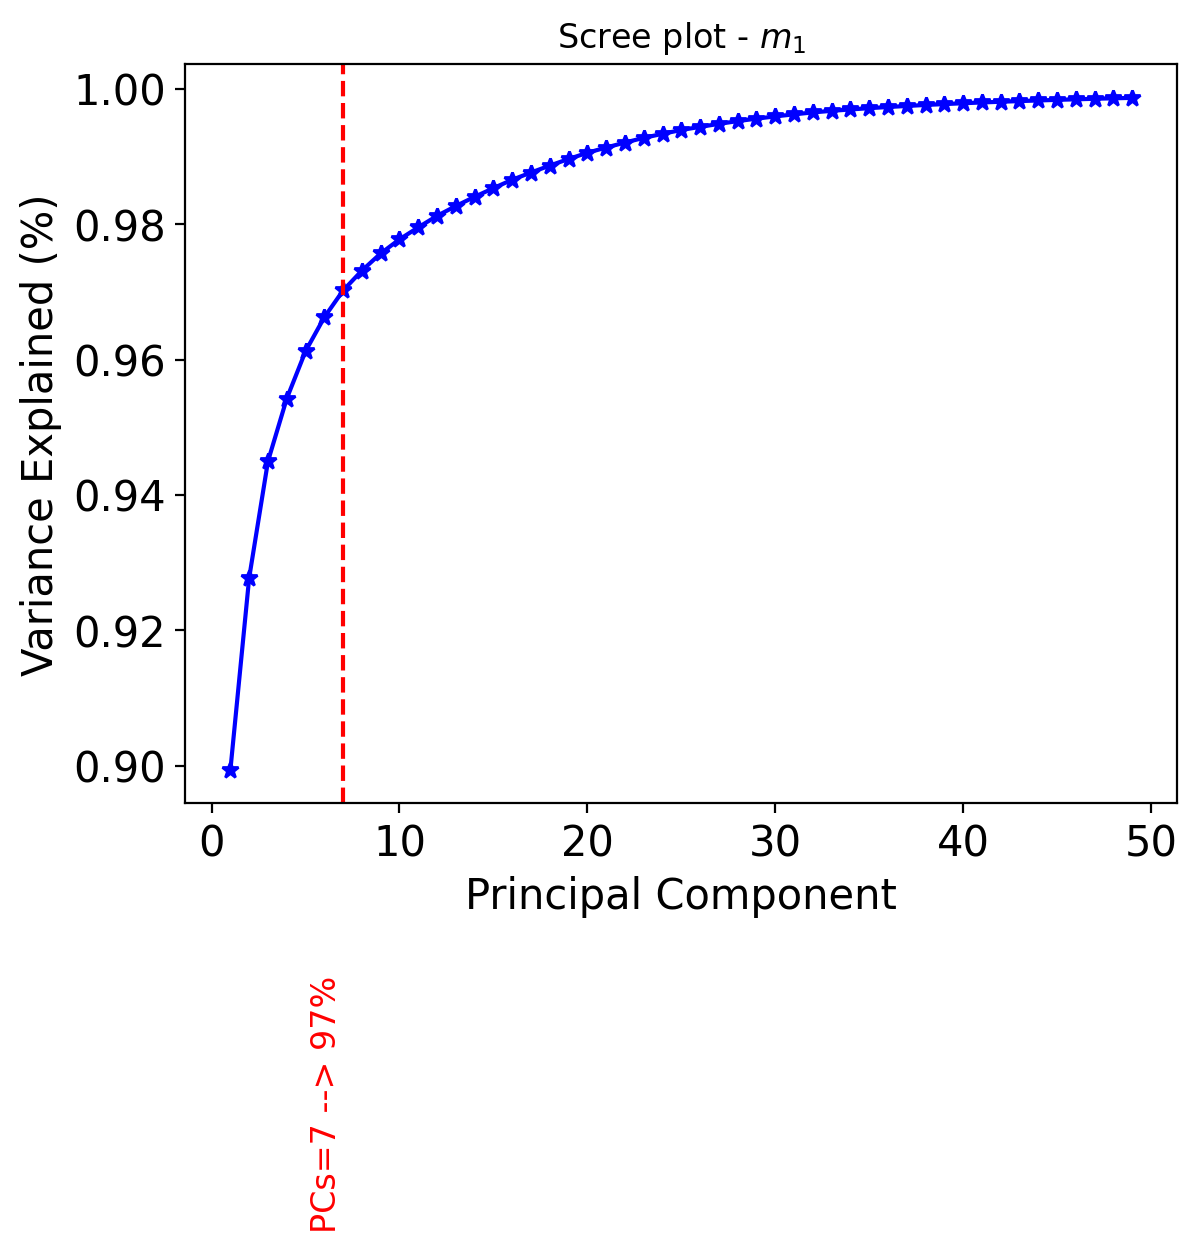

In [217]:
plt.figure()  # Scree plot
X = np.arange(1, n_realizations)
Y = np.cumsum(explained)
N = 49  # number of pcs to plot in scree plot
plt.plot(X[:N], Y[:N], '*-b')
plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Variance Explained (%)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=x_m_1, color='red', linestyle='--')
plt.text(x_m_1, 0.85, f'PCs={x_m_1} --> 97%', va='center', ha='right', color='red', fontsize=12, rotation=90)

plt.title('Scree plot - $m_1$') #change name depending on variable

# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'Scree_plot_m_1.png', dpi=300)

plt.show()

**Figure — Scree Plot of PCA for $m_1$ (Surface UQ).**
The red dashed line indicates the number of principal components ($x_{\text{m1}}$) required to explain 97–99 % of the variance.
These retained PCs are later used in the DGSA and in building the KDE-based proposal distribution $g(m)$.

In [223]:
# Principal component analysis (PCA) - porosity m2
# load and transpose the data
data = np.transpose(m_2) 
pca = PCA()
pcs = pca.fit_transform(data)
m_2_score = pcs[:, :n_realizations]  # Extract the scores for the first nmodels
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
# Save the scores
np.save(OUTPUTS_FOLDER + 'm_2score_' + case_name + '.npy', m_2_score)

In [224]:
# find how many PCs to use in DGSA
threshold = 0.96 # 96% explained variance
cumulative_sum = 0.0
x_m_2 = 0 # number of PC scores that represent 99% variance. Change Name: x_phi / x_surf / x_CO2
while cumulative_sum < threshold:
    cumulative_sum += explained[x_m_2]
    x_m_2 += 1
print("x_m_2:", x_m_2)
PC_m2_labels = [f"PC{i}-m2" for i in range(1, x_m_2+1)]

x_m_2: 266


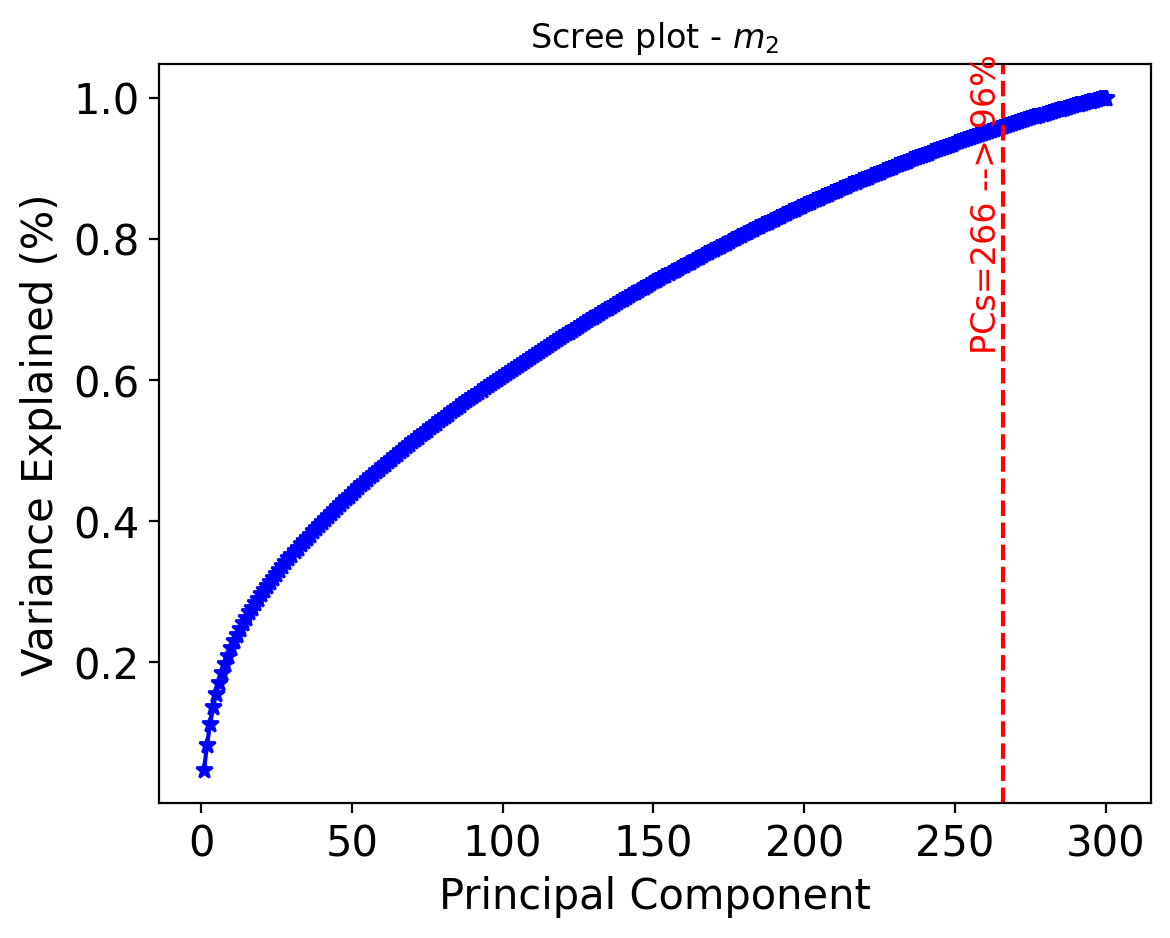

In [225]:
# Scree plot
plt.figure()
X = np.arange(1, len(explained) + 1)
Y = np.cumsum(explained)
N = len(explained)  # Ensure you're plotting only what's available
plt.plot(X[:N], Y[:N], '*-b')
plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Variance Explained (%)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=x_m_2, color='red', linestyle='--')
plt.text(x_m_2, 0.85, f'PCs={x_m_2} --> 96%', va='center', ha='right', color='red', fontsize=12, rotation=90)

plt.title('Scree plot - $m_2$') #change name depending on variable

# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'Scree_plot_m_2.png', dpi=300)

plt.show()

In [227]:
# Principal component analysis (PCA) - CO2 sat height - h2
# load and transpose the data
data = np.transpose(h_2)
# PCA
pca = PCA()
pcs = pca.fit_transform(data)
h_2_score = pcs[:, :n_realizations]  # Extract the scores for the first nmodels
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
# Save the scores
np.save(OUTPUTS_FOLDER + 'h_2score_' + case_name + '.npy', h_2_score)

In [228]:
# find how many PCs to use in DGSA
threshold = 0.99 # 99% explained variance
cumulative_sum = 0.0
x_h_2 = 0 # number of PC scores that represent 99% variance. Change Name: x_phi / x_surf / x_CO2
while cumulative_sum < threshold:
    cumulative_sum += explained[x_h_2]
    x_h_2 += 1
print("x_CO2:", x_h_2)
PC_h2_labels = [f"PC{i}-h2" for i in range(1, x_h_2+1)]

x_CO2: 47


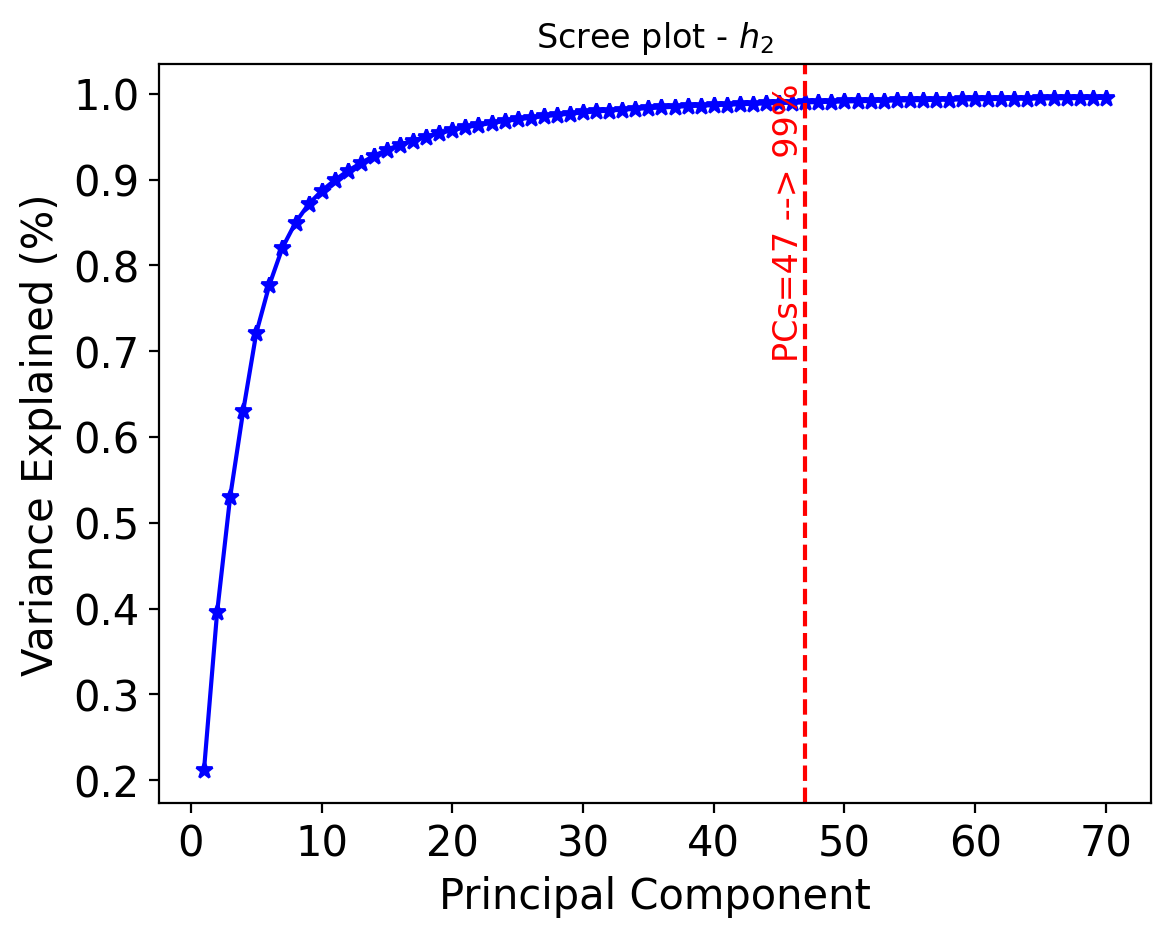

In [229]:
plt.figure()  # Scree plot
X = np.arange(1, n_realizations)
Y = np.cumsum(explained)
N = 70  # number of pcs to plot in scree plot
plt.plot(X[:N], Y[:N], '*-b')
plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Variance Explained (%)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=x_h_2, color='red', linestyle='--')
plt.text(x_h_2, 0.85, f'PCs={x_h_2} --> 99%', va='center', ha='right', color='red', fontsize=12, rotation=90)

plt.title('Scree plot - $h_2$') #change name depending on variable

# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'Scree_plot_h_2.png', dpi=300)

plt.show()



### Step 5.2 — Importance Sampling: Perform DGSA on PCA scores to identify sensitive components

Next, we perform **Distance-based Global Sensitivity Analysis (DGSA)** on the PCA scores to identify which components of the inputs most influence CO₂ leakage.

**Workflow summary:**

1. **Assemble inputs:**
   Combine PCA scores from top-surface (`m₁`) and porosity (`m₂`) as `parameters`,
   and concatenate leakage volume with CO₂-saturation PCA scores (`h₂`) as `responses`.
2. **Run DGSA:**
   Use `DGSA_light(parameters, responses)` to compute sensitivity measures for all PCA components.
3. **Visualize and save:**
   Save the DGSA results (`dgsa_measures_<case>.npy`) and plot the Pareto ranking (`DGSA.png`).

**Outcome:**
The most sensitive PCA components indicate which model variables (in `m₁` and `m₂`) most strongly drive failura ($CO_2$ leakage). These will define the variables used to construct the proposal distribution $g(m)$ for Importance Sampling.

Note: The DGSA results may vary slightly each time the code is run because the algorithm includes random processes. 


In [248]:
%cd DGSA_Light

/Users/sofiamantillasalas/Documents/GitHub_Sofia/CCS_structure/Jupyter_scripts_and_functions/DGSA_Light/DGSA_Light/DGSA_Light


In [236]:
from DGSA_light import DGSA_light
from gsa_pareto_plt import gsa_pareto_plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [254]:
# Prepare parameters and responses for DGSA
# load leakage volume
leakage_volume = np.load(INPUTS_POST_SIM_FOLDER + 'leakage_volume.npy')
parameters = np.concatenate((m_1_score[:,:x_m_1], m_2_score[:,:x_m_2]), axis=1) # scores from surfaces, porosity models
responses = np.concatenate((leakage_volume, h_2_score[:, :x_h_2]), axis=1)

PC_all_labels = PC_m1_labels + PC_m2_labels # list with the parameters names to be used in DGSA

In [255]:
dgsa_measures = DGSA_light(parameters, responses, ParametersNames = PC_all_labels)
# store DGSA
np.save(OUTPUTS_FOLDER + 'dgsa_measures_' + case_name + '.npy', dgsa_measures)

100%|██████████| 3000/3000 [00:19<00:00, 155.96it/s]


In [ ]:
# Run this cell if you want to reproduce the paper DGSA plot. Remember the DGSA results may vary slightly each time the code is run because the algorithm includes random processes. 
dgsa_measures = np.load(INPUTS_POST_SIM_FOLDER +'dgsa_measures.npy') # load DGSA from paper. 
# Convert dgsa_measures (numpy array) to a DataFrame
dgsa_measures = pd.DataFrame(dgsa_measures)

<Figure size 1000x800 with 0 Axes>

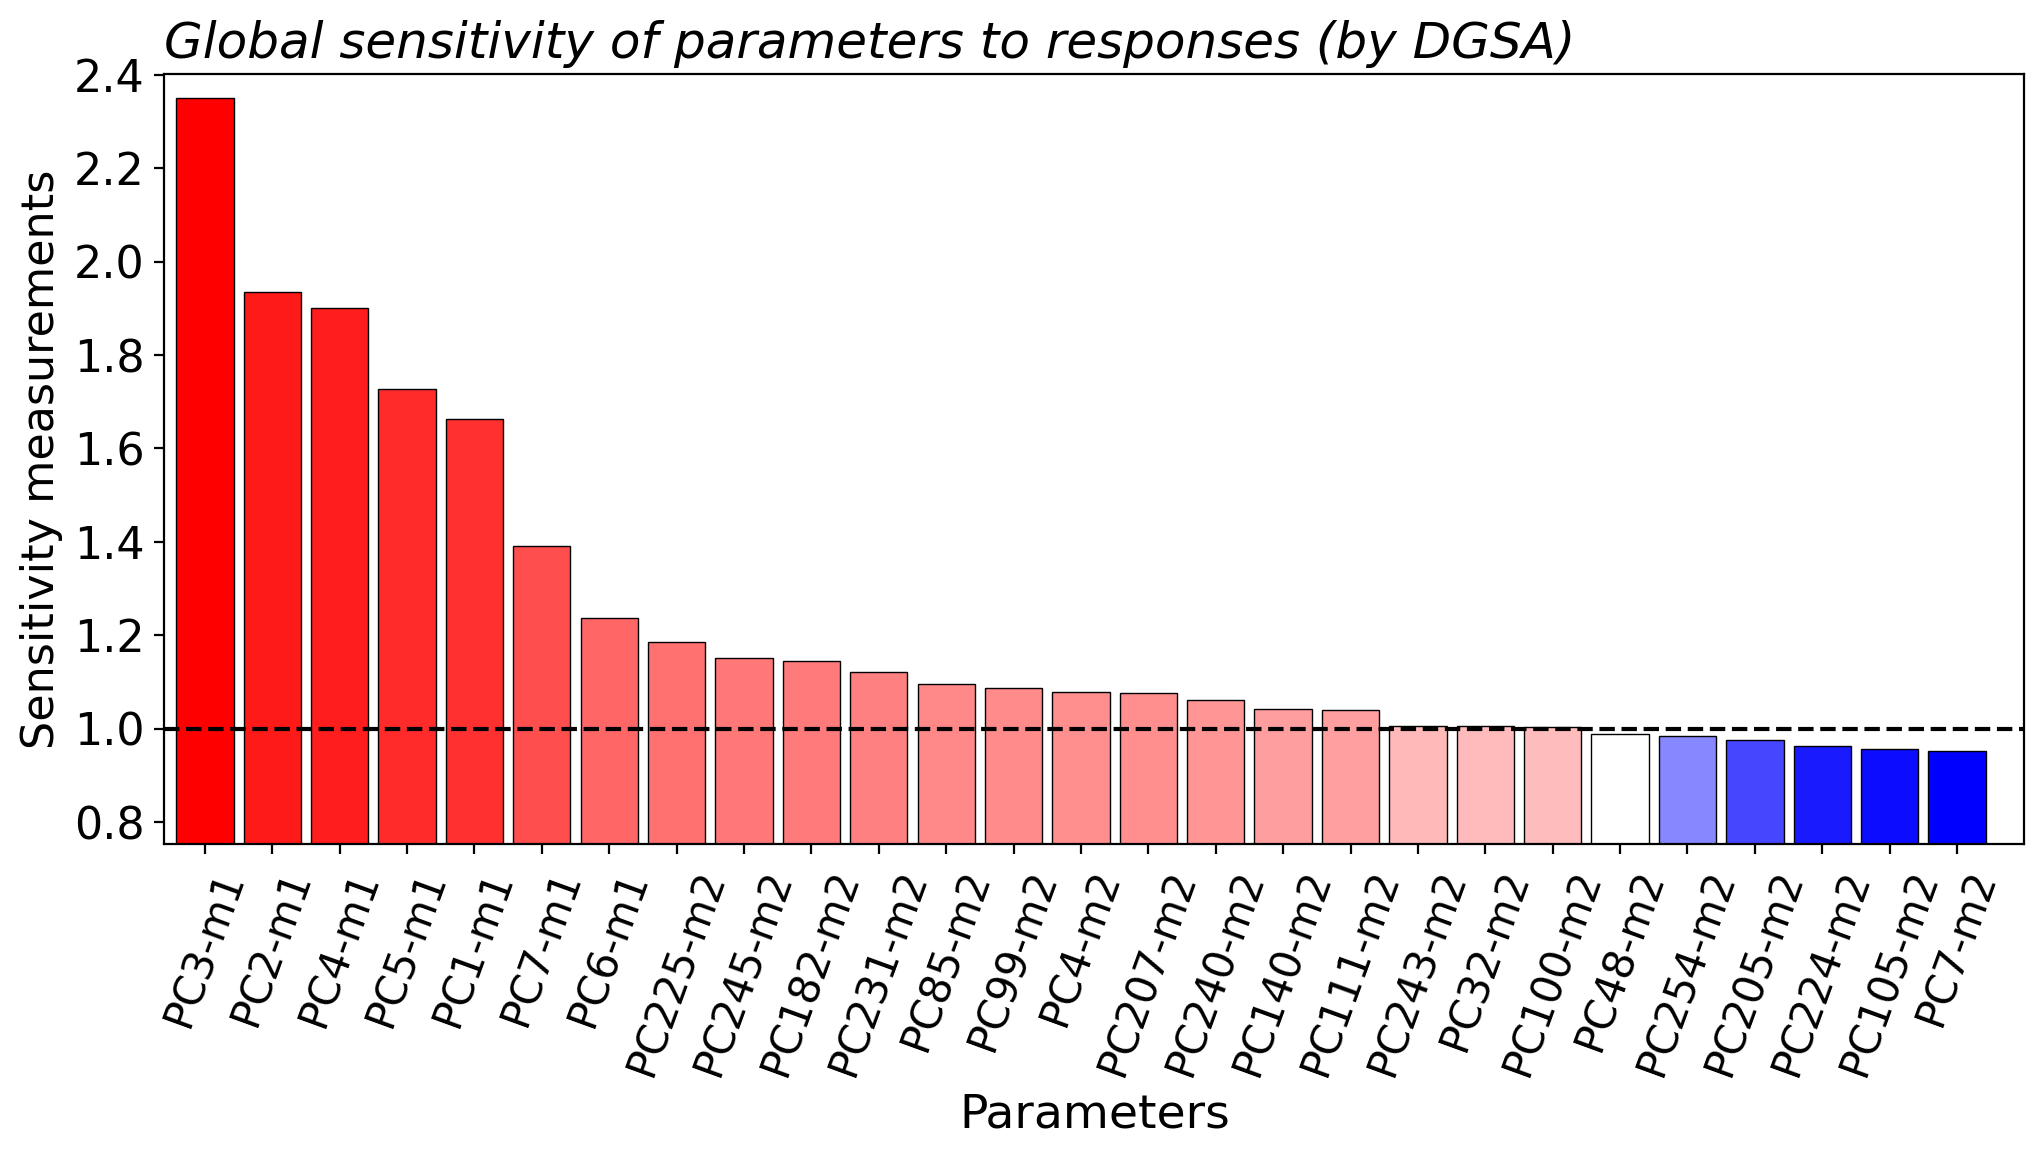

In [256]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
gsa_pareto_plt(dgsa_measures)
# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'DGSA.png', dpi=300, bbox_inches='tight')
plt.show()

### Step 5.3 - Importance Sampling: Fit MKDE (Multivariate Kernel Density Estimation) on sensitive PC scores to construct the IS alternative distribution g(m)

We now perform **Multivariate Kernel Density Estimation (MKDE)** on the normalized scores of the most leakage-sensitive principal components to define both the **target distribution** $f(m)$ and the **proposal (alternative) distribution** $g(m)$ used in Importance Sampling.

**Workflow summary:**

1. **Estimate overall density:**
   Fit a KDE on the sensitive PC scores of **all models** → this defines the **target distribution** $f(m)$, representing the full ensemble of geological realizations.
2. **Estimate leakage-biased density:**
   Fit a second KDE on the **leaking models only** (`failure_sensitive_scores`) → this defines the **proposal distribution** $g(m)$, which concentrates probability mass in regions of parameter space associated with leakage.
   The same bandwidth from $f(m)$ is used for $g(m)$ to ensure consistent smoothing.
3. **Store distributions:**
   Save both `f_m` and `g_m` as `.pkl` objects for later use in the Importance Sampling workflow.
4. **Evaluate leakage probability density:**
   Compute

  $$
  pdf_{failure} = g(m).pdf(all_sensitive_scores)
  $$

   to estimate how likely each realization is to produce leakage under the proposal $g(m)$.

**Outcome:**
$f(m)$ captures the baseline variability of all geological models, while $g(m)$ targets the leakage-prone subset—forming the foundation for weighted resampling in the Importance Sampling procedure.

In [ ]:
# generate df with just normalized sensitive scores and ranked list of first 7 sensitive PCs

# first add labels
dgsa_measures['PC_label'] = PC_all_labels
dgsa_measures_sorted = dgsa_measures.iloc[dgsa_measures.iloc[:, 0].argsort()[::-1], :]
idx_sen = dgsa_measures_sorted.iloc[:7]

# Create new dataframe with sensitive scores
parameters_df = pd.DataFrame(parameters)
parameters_df.loc[-1] = dgsa_measures.iloc[:, 0].values
parameters_df.index = parameters_df.index + 1
parameters_df = parameters_df.sort_index()
# Create a new DataFrame with the PC_all_labels as the first row
new_row = pd.DataFrame([PC_all_labels], columns=parameters_df.columns)
# Concatenate the new row with the existing DataFrame
parameters_df = pd.concat([new_row, parameters_df], ignore_index=True)
# Sort dataframe of scores by order of sensitivity
selected_columns = parameters_df.columns[parameters_df.iloc[0].isin(idx_sen.iloc[:,1])]
selected_parameters_df = parameters_df[selected_columns]
selected_parameters_df = selected_parameters_df.reindex(sorted(selected_parameters_df.columns, key=lambda x: selected_parameters_df.iloc[1, selected_parameters_df.columns.get_loc(x)], reverse=True), axis=1)
selected_parameters_df = selected_parameters_df.iloc[1:]
para_sen = selected_parameters_df.drop(selected_parameters_df.index[0:1]) 

# Normalize the values in para_sen DataFrame = normalized sensitive scores 
stn_para_sen = (para_sen - para_sen.mean()) / para_sen.std()# this will be used in MKDE after normalization

# now drop the first column of idx_sen 
idx_sen = idx_sen.iloc[:,1] # Ranked list of first 7 sensitive PCs --> this will be used in MKDE

# Creation of DataFrame with normalized sensitive scores of models that leaked
stn_para_sen_fail = stn_para_sen[h_1 == 1].copy()

import pickle
# store variables for MKDE
np.save(OUTPUTS_FOLDER + 'stn_para_sen_fail_' + case_name + '.npy', stn_para_sen_fail)
# Specify the file path for saving idx_sen
idx_sen_file_path = OUTPUTS_FOLDER + 'idx_sen_' + case_name + '.pickle'
# Save idx_sen using pickle.dump()
with open(idx_sen_file_path, "wb") as file:
    pickle.dump(idx_sen, file)

In [ ]:
# Re-sampling with Multivariate KDE
# Load Scores
all_sensitive_scores= stn_para_sen.astype('float64') # sensitive scores of all surfaces
failure_sensitive_scores = stn_para_sen_fail.astype('float64') # sensitive scores of surfaces that produced leakage
# store variables for MKDE
np.save(OUTPUTS_FOLDER + 'all_sensitive_scores_' + case_name + '.npy', all_sensitive_scores)
np.save(OUTPUTS_FOLDER + 'failure_sensitive_scores_' + case_name + '.npy', failure_sensitive_scores)

In [ ]:
# Multivariate Kernel Density Estimation - max 7 dimensions
f_m = sm.nonparametric.KDEMultivariate(data=[all_sensitive_scores], var_type='ccccccc') # 'c' for continuous variables, number of 'c's = number of dimensions
bw = f_m.bw # get bandwidth from all sensitive scores
g_m = sm.nonparametric.KDEMultivariate(data=[failure_sensitive_scores], bw=bw, var_type='ccccccc') # use same bandwidth as all sensitive scores

# Save f_m to a file
with open(OUTPUTS_FOLDER + 'f_m_' + case_name + '.pkl', 'wb') as file:
    pickle.dump(f_m, file)

# Save g_m to a file
with open(OUTPUTS_FOLDER + 'g_m_' + case_name + '.pkl', 'wb') as file:
    pickle.dump(g_m, file)
pdf_failure = g_m.pdf(all_sensitive_scores) # evaluate failure pdf at all sensitive scores

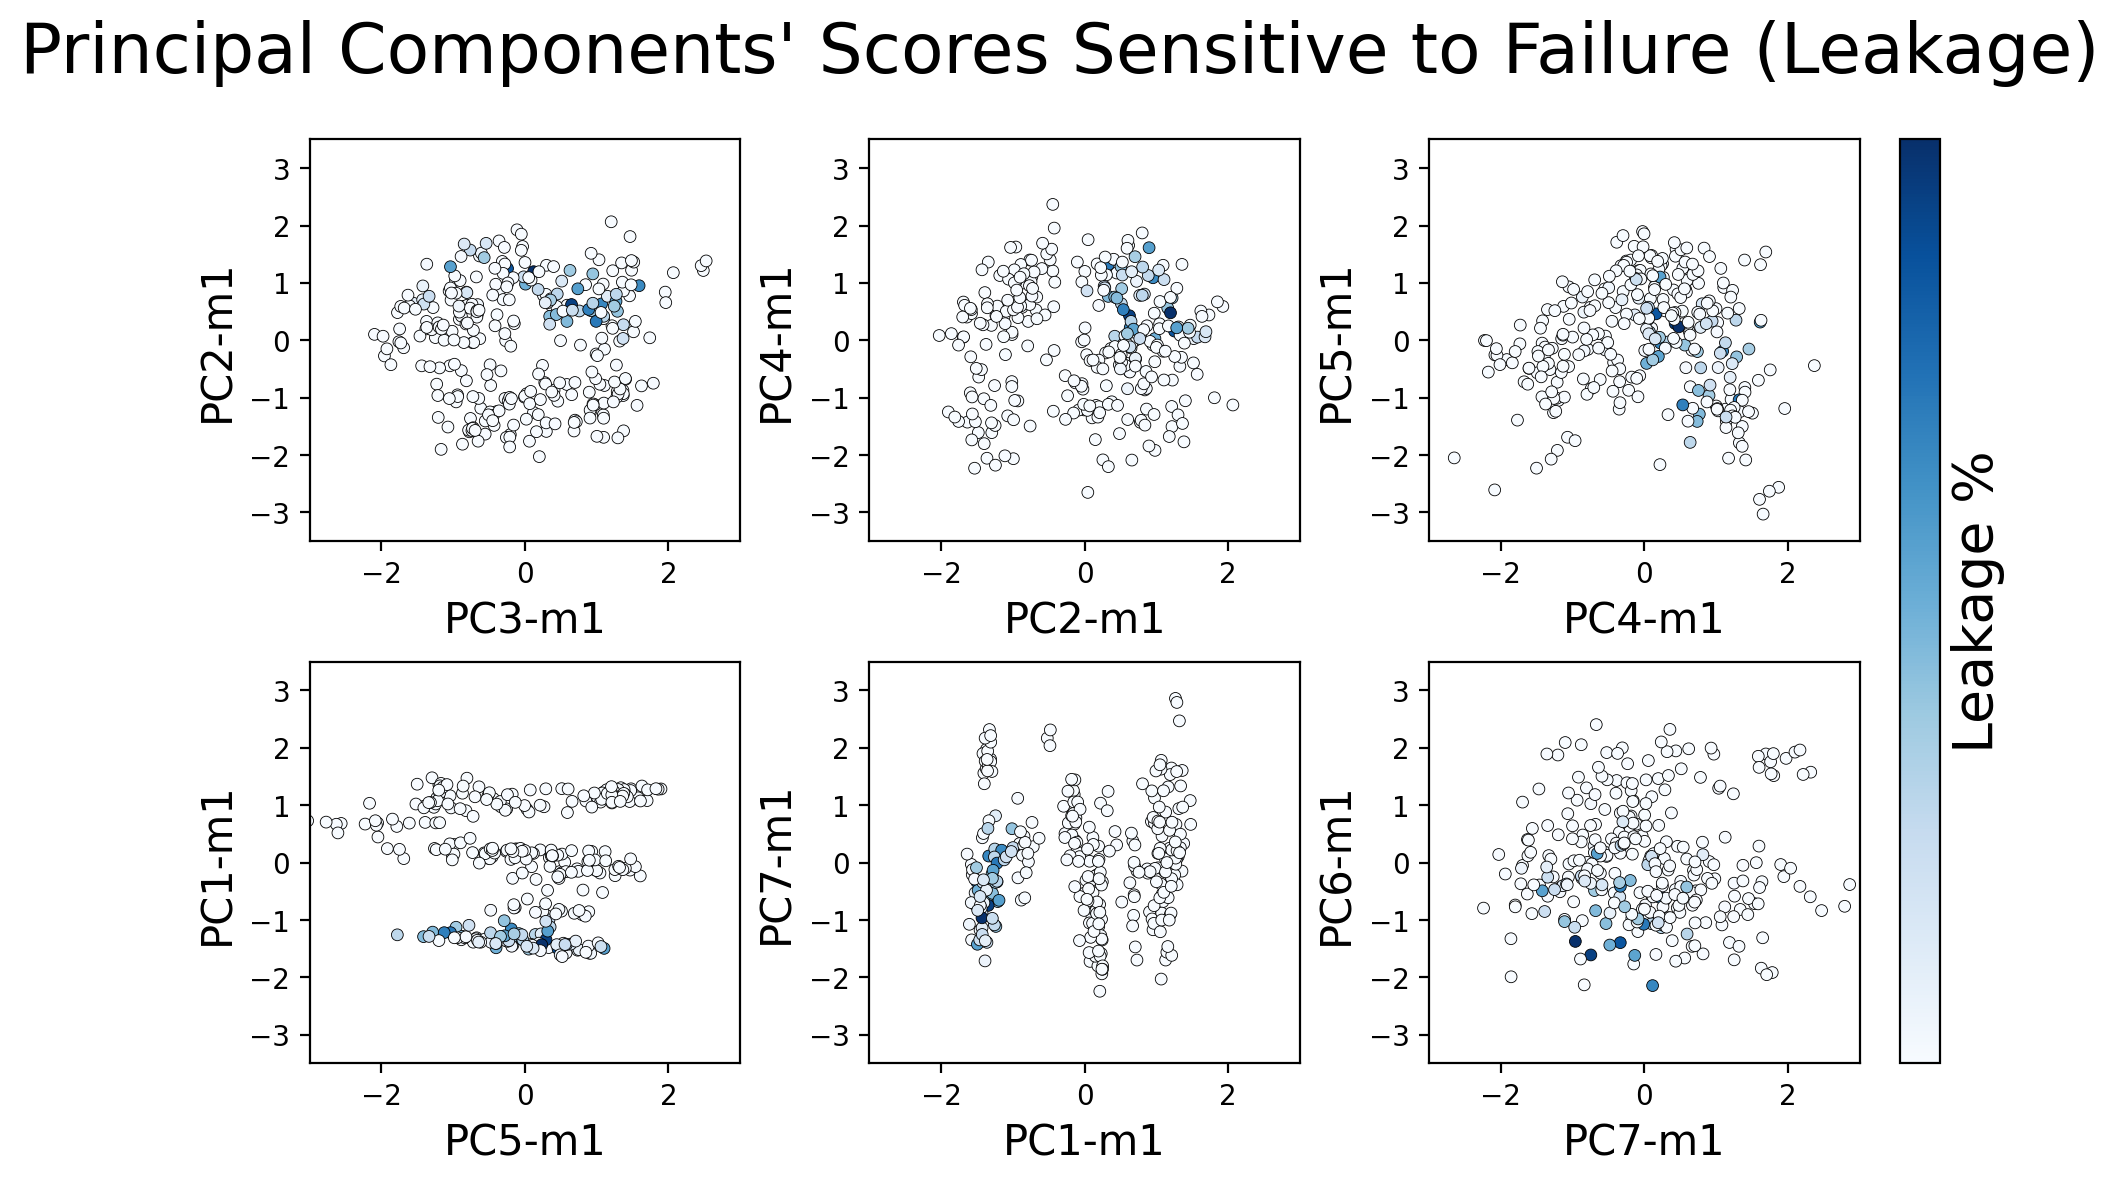

In [278]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1])

for i in range (0,6):
   plt.subplot(2,3,i+1)
   plt.scatter(all_sensitive_scores.iloc[:,i], all_sensitive_scores.iloc[:,i+1],c=pdf_failure, cmap='Blues',edgecolors='k', linewidths=0.3, s=18)
   plt.xlim(-3, 3)
   plt.ylim(-3.5,3.5) 
   plt.xlabel(idx_sen[i], fontsize = 15)
   plt.ylabel(idx_sen[i+1], fontsize = 15)
   plt.suptitle("Principal Components' Scores Sensitive to Failure (Leakage)", fontsize = 25) 

plt.subplots_adjust(wspace=0.3, hspace =0.3)  # Adjust the spacing between columns    

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Define the position of the color bar
cbar = plt.colorbar(cax=cbar_ax, ticks=[], cmap='Blues')
cbar.set_label('Leakage %', fontsize=20)

# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'MKDE.png', dpi=300, bbox_inches='tight')

plt.show()

### Step 5.4 — Importance Sampling: Resample New PC Scores from $g(m)$

We now perform **resampling** in the reduced PC space to generate new model realizations that are more likely to produce CO₂ leakage. This step draws samples from the **proposal distribution** $g(m)$, using **rejection sampling** guided by the ratio $f(m) / g(m)$.

**Workflow summary:**

1. **Define densities:**

   * $f(m)$: KDE of all models (target distribution).
   * $g(m)$: KDE of leakage-prone models (proposal distribution).

2. **Resample via rejection sampling:**

   * Randomly sample candidate points from $g(m)$.
   * Evaluate both $f(m)$ and $g(m)$ at those points.
   * Accept samples with probability proportional to $f(m)/g(m)$.
   * Continue until the desired number of resamples $( n = 300 )$ is reached.

3. **Visualize results:**
   * Overlay the resampled PC scores $( m' \sim g(m) )$ on the original score space to confirm they cluster near leakage regions.

**Outcome:**
This step produces a **resampled ensemble** of parameter combinations that are concentrated in regions where leakage is more probable, significantly improving sampling efficiency. These weighted samples will be used to reconstruct new realizations and estimate leakage probability with far fewer forward simulations.


In [279]:
from sklearn.neighbors import KernelDensity

def RS(SA_surf_leak_scores, fx_bw, gx_bw=188, n_smpl=300):
    # Target KDE: statsmodels for f(x)
    mkde_target = sm.nonparametric.KDEMultivariate(data=[SA_surf_leak_scores], bw=fx_bw, var_type='ccccccc')
    
    # Proposal KDE: sklearn for g(x)
    kde_proposal = KernelDensity(kernel='gaussian', bandwidth=gx_bw).fit(SA_surf_leak_scores)

    n_rs = 0
    RS_final = np.zeros((0, SA_surf_leak_scores.shape[1]))
    itrnum = 0

    while n_rs < n_smpl:
        print('progress= %', 100 * np.round(n_rs / n_smpl, 2))
        N_POINTS_RESAMPLE = 100000

        # Sample from proposal g(x)
        resample_gx = kde_proposal.sample(N_POINTS_RESAMPLE)

        # Evaluate f(x) and g(x)
        resample_fpdf = mkde_target.pdf(resample_gx.T)  # note transpose: shape (d, n)
        resample_gpdf = np.exp(kde_proposal.score_samples(resample_gx))  # already shape (n,)

        # Compute acceptance constant
        c = np.max(resample_fpdf / (resample_gpdf + 1e-12))
        u = np.random.uniform(0, c * resample_gpdf)

        RS_samples_idx = np.argwhere(resample_fpdf >= u)[:, 0]
        RS_final = np.r_[RS_final, resample_gx[RS_samples_idx]]

        itrnum += 1
        n_rs = len(RS_final)

    print('Acceptance Rate =', len(RS_final) / (100000 * itrnum))
    return RS_final[:n_smpl]


In [ ]:
# Resample # number of failure_sensitive_scores
n_re_smpl=300
RS_failure_sensitive_scores = RS(failure_sensitive_scores, fx_bw=bw, gx_bw=bw.mean(), n_smpl=n_re_smpl) # Re-sampling with Multivariate KDE
np.save(OUTPUTS_FOLDER + 'RS_failure_sensitive_scores_' + case_name + '.npy', RS_failure_sensitive_scores)

progress= % 0.0
Acceptance Rate = 1.0


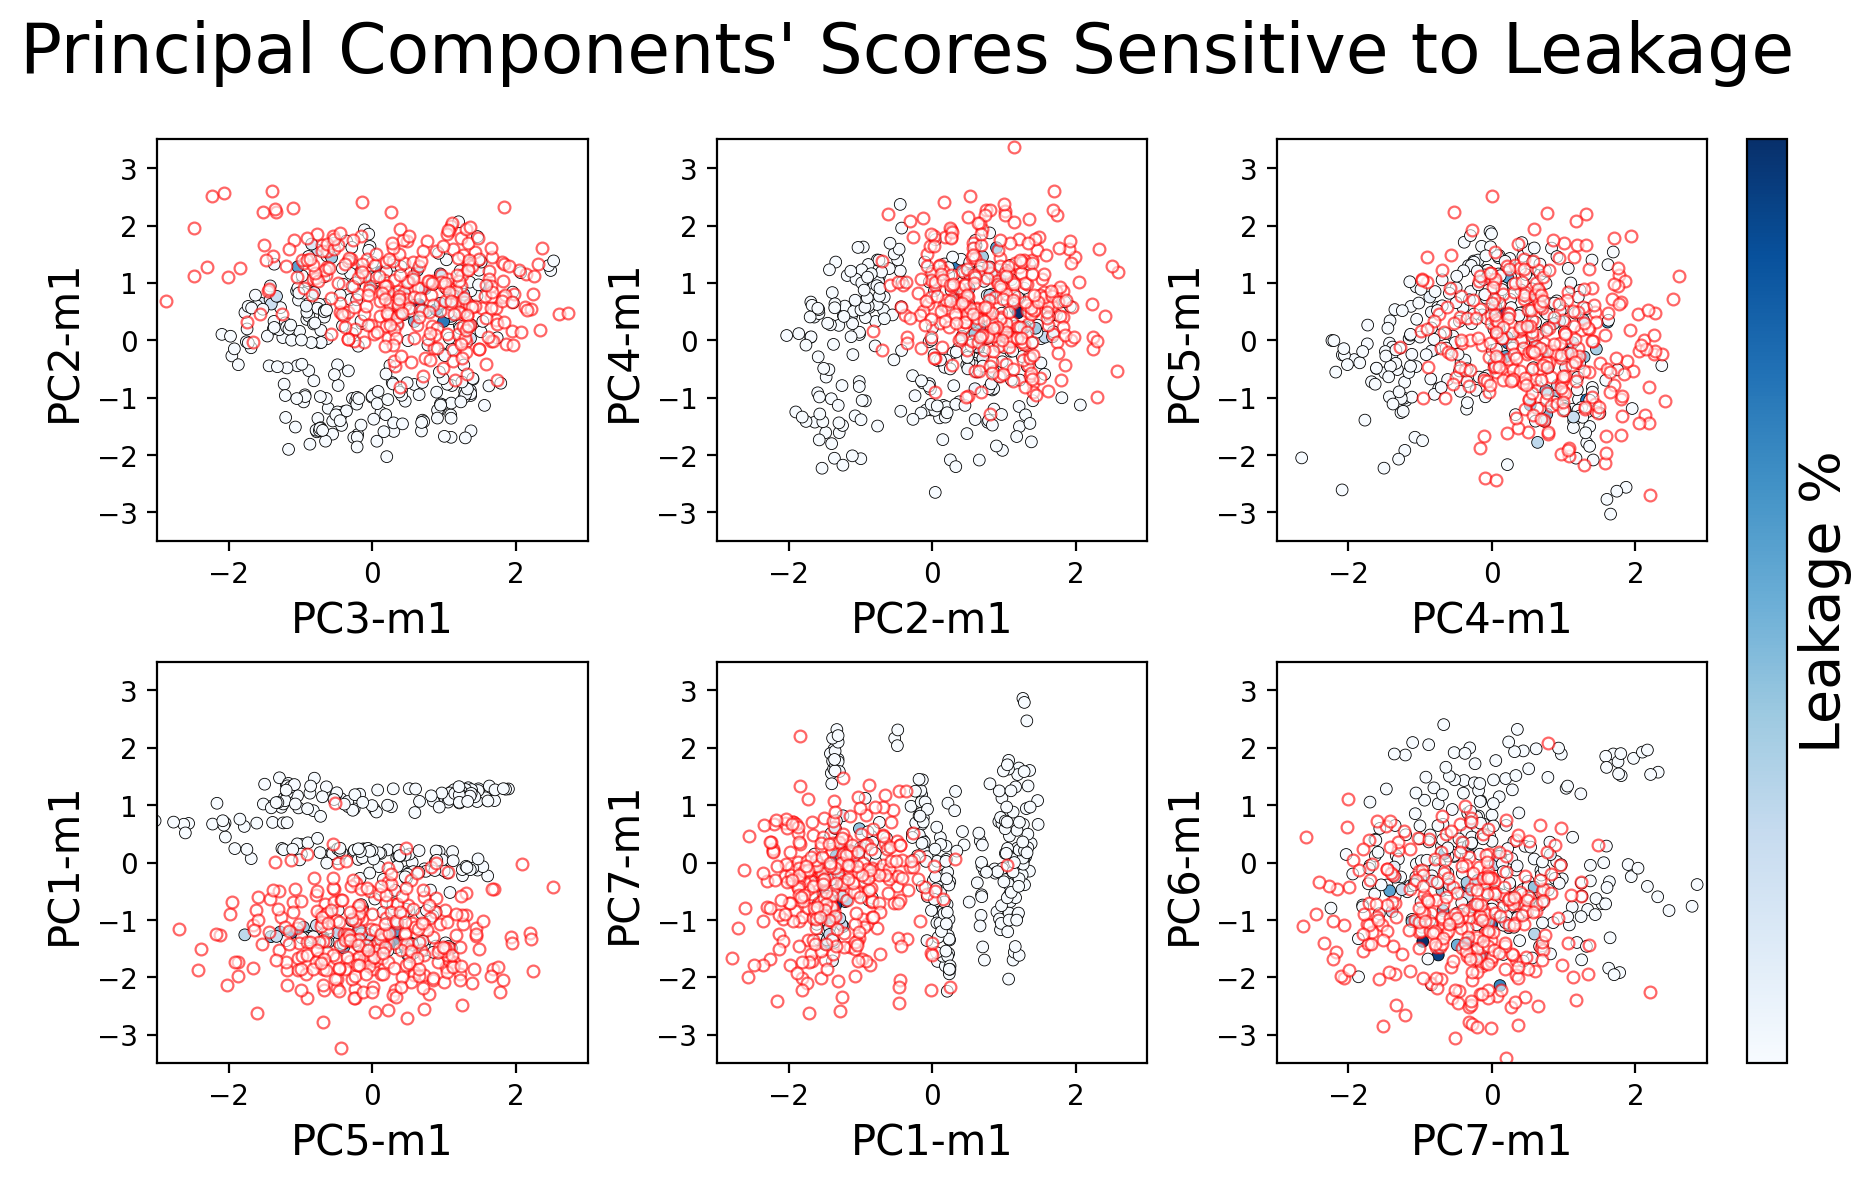

In [ ]:
# Figure with original parameters and resampled parameters
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1])

for i in range (0,6):
    ax = plt.subplot(2,3,i+1)
    plt.scatter(all_sensitive_scores.iloc[:,i], all_sensitive_scores.iloc[:,i+1], c=pdf_failure, cmap='Blues', edgecolors='k', linewidths=0.3, s=18)
    plt.scatter(RS_failure_sensitive_scores[:,i], RS_failure_sensitive_scores[:,i+1], c='white', cmap='Grey', edgecolors='r', linewidths=0.8, s=18, alpha=0.6)
    plt.xlim(-3, 3)
    plt.ylim(-3.5, 3.5) 
    plt.xlabel(idx_sen[i], fontsize=15)
    plt.ylabel(idx_sen[i+1], fontsize=15)
    plt.suptitle("Principal Components' Scores Sensitive to Failure (Leakage)", fontsize=25) 

cmap = cm.get_cmap('Blues')
sm = cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # Set an empty array to map the colormap properly

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Define the position of the color bar
cbar = plt.colorbar(sm, cax=cbar_ax,ticks=[])
cbar.set_label('Leakage %', fontsize=20)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between columns   

# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'MKDE_resampled.png', dpi=300, bbox_inches='tight')

plt.show()

### Step 5.5 — Reconstruct $m_1', m_2'$ from Resampled PC Scores

We map the **resampled sensitive PC scores** back to the original model spaces (top-surface $m_1$ and porosity $m_2$) to create posterior fields for flow simulation.

**Workflow summary**

1. **Unstandardize resampled scores**
   Convert normalized resampled scores back to data space using the mean/std of the selected PCs:
   (\text{score}*{\text{un}} = \text{score}*{\text{std}} \cdot \sigma + \mu).

2. **Merge with full PC score tables**
   Replace only the **top-k sensitive PCs** in the full PC score matrices, keeping the remaining PCs unchanged to preserve total variance up to the chosen cutoff.

3. **PCA-based reconstruction**
   For each variable $(m_1), (m_2)$:

   * Fit PCA on the prior sample matrix (for consistent eigenvectors/means).
   * Reconstruct fields with: (\hat{X} = \bar{X} + S_{\text{upd}} , P),
     where (S_{\text{upd}}) are the updated scores and (P) are PCA loadings.

4. **Post-processing & export**

   * Enforce physical bounds (e.g., clip (\phi > 0)).
   * Save reconstructed arrays to **MATLAB .mat** files (`m_1.mat`, `m_2.mat`) for MRST flow runs.

5. **Visualization**

   * Side-by-side 2D maps and 3D surfaces compare **NMC (prior)** vs **IS (reconstructed)** realizations to confirm structural/porosity shifts induced by IS.

**Outcome**
Posterior realizations (m_1', m_2') reflect **leakage-biased** patterns in the sensitive subspace while retaining global variability—ready for forward simulation to evaluate IS efficiency and updated leakage risk.


In [ ]:
# Non-standarization of resampled posterior scores for surfaces and phi reconstruction
ndim = 7 # dimensions used in MKDE

RS_failure_sensitive_scores_un = np.zeros((n_re_smpl, ndim))  # initialize the array for unstandardized scores

for j in range(ndim):
    for i in range(n_re_smpl):
        RS_failure_sensitive_scores_un[i, j] = (RS_failure_sensitive_scores[i, j] * np.std(para_sen.iloc[:, j])) + np.mean(para_sen.iloc[:, j])

# Consolitaiton of the parameters score table including the resampled scores too
RS_failure_sensitive_scores_un_df = pd.DataFrame(RS_failure_sensitive_scores_un) #  Non-standarization of resampled posterior scores for surfaces and phi reconstruction
pc = stn_para_sen.columns.tolist() # list in order of sensitivity of the numbers of the PCs 
RS_failure_sensitive_scores_un_df.columns = pc # rename header

all_para_score = np.concatenate((m_1_score[:n_re_smpl, :x_m_1], m_2_score[:n_re_smpl, :x_m_2]), axis=1) #create array with prior surf and phi scores that explain 99% pf the variance
all_para_score_df = pd.DataFrame(all_para_score)

RS_failure_para_score = all_para_score_df.copy() 
RS_failure_para_score.update(RS_failure_sensitive_scores_un_df) # create a df with re-sampled posterior phi and surf scores

# create separate df for surfaces and phi scores
m_1_score_upd = pd.DataFrame(m_1_score[:n_re_smpl,:n_re_smpl].copy())
m_1_score_upd.iloc[:,:x_m_1] =RS_failure_para_score.iloc[:,:x_m_1]  # resampled updated surfaces scores to be used for reconstruction
m_2_score_upd = pd.DataFrame(m_2_score[:n_re_smpl,:n_re_smpl].copy())
m_2_score_upd.iloc[:,:x_m_2] =RS_failure_para_score.iloc[:,x_m_1:]  # resampled updated surfaces scores to be used for reconstruction

# posterior surfaces reconstruction
m_1_ex = m_1[:,:n_re_smpl] #example of prior surfaces
data = np.transpose(m_1_ex)  # Assuming crop_tsurf is the input data
nextractpc = n_re_smpl - 1

# Perform PCA
pca = PCA(n_components=nextractpc)
pca.fit(data)
pcs =  pca.components_ # Transpose the data
score = m_1_score_upd.iloc[:, :nextractpc]  # Replace with the desired score, sliced to nextractpc columns

# Reconstruct the data
dataapprox = np.dot(score, pcs)
datamean = np.mean(data, axis=0)
datamean_reshaped = datamean.reshape(1, -1)  # Reshape datamean to (1, 19136)
datamean_broadcasted = np.tile(datamean_reshaped, (dataapprox.shape[0], 1))
ReconstructData = datamean_broadcasted + dataapprox
ReconstructData = ReconstructData.T

# EXPORT to MATLAB for flow simulation in MRST
# Convert ReconstructData to double
m_1 = ReconstructData.astype(float)
# Create a dictionary to store the data
data_dict = {'m_1': m_1}
# Save the data as a MATLAB .mat file
savemat(OUTPUTS_FOLDER + 'm_1.mat', data_dict)

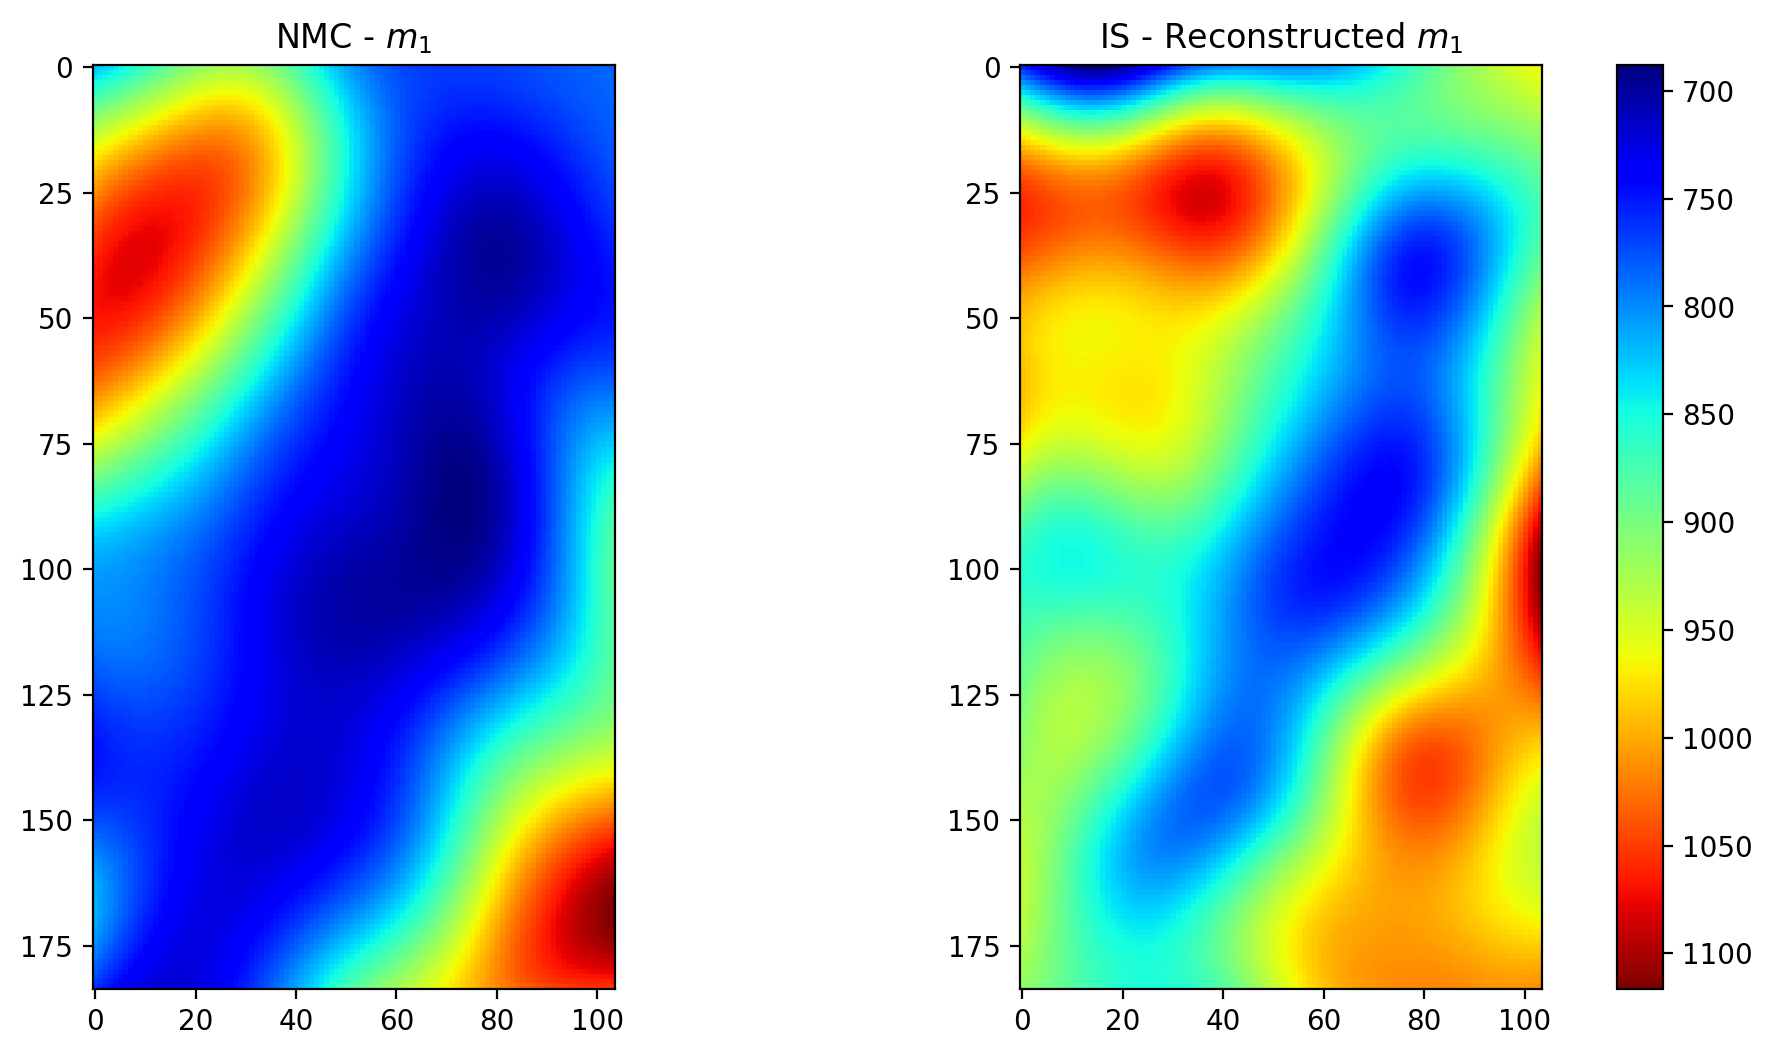

In [292]:
# Plot comparing prior and posterior surfaces
fig_n = 55 # index of the realization to plot (user-defined)
grid_shape = (184, 104) # shape of the grid for surfaces (user-defined)
reconstructed_column = ReconstructData[:, fig_n].reshape(grid_shape)
m_1_column = m_1_ex[:, fig_n].reshape(grid_shape)
# Flip the data horizontally
reconstructed_column = np.fliplr(reconstructed_column)
m_1_column = np.fliplr(m_1_column)
# Create a grid of x, y coordinates
x = np.arange(grid_shape[1])
y = np.arange(grid_shape[0])
X, Y = np.meshgrid(x, y)
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
# Plot 'ReconstructData' on the second subplot
ax1 = axes[0]
im1 = ax1.imshow(np.flipud(m_1_column), cmap='jet')  # Flip the image vertically
ax1.set_title('NMC - $m_1$')
# Plot 'surfaces' on the first subplot
ax2 = axes[1]
im2 = ax2.imshow(np.flipud(reconstructed_column), cmap='jet')
ax2.set_title('IS - Reconstructed $m_1$')
# Create a colorbar for the subplots
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.046, pad=0.04)  # Set orientation to 'vertical'
# Invert the colorbar
cbar.ax.invert_yaxis()
# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + 'm_1_reconstruction.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

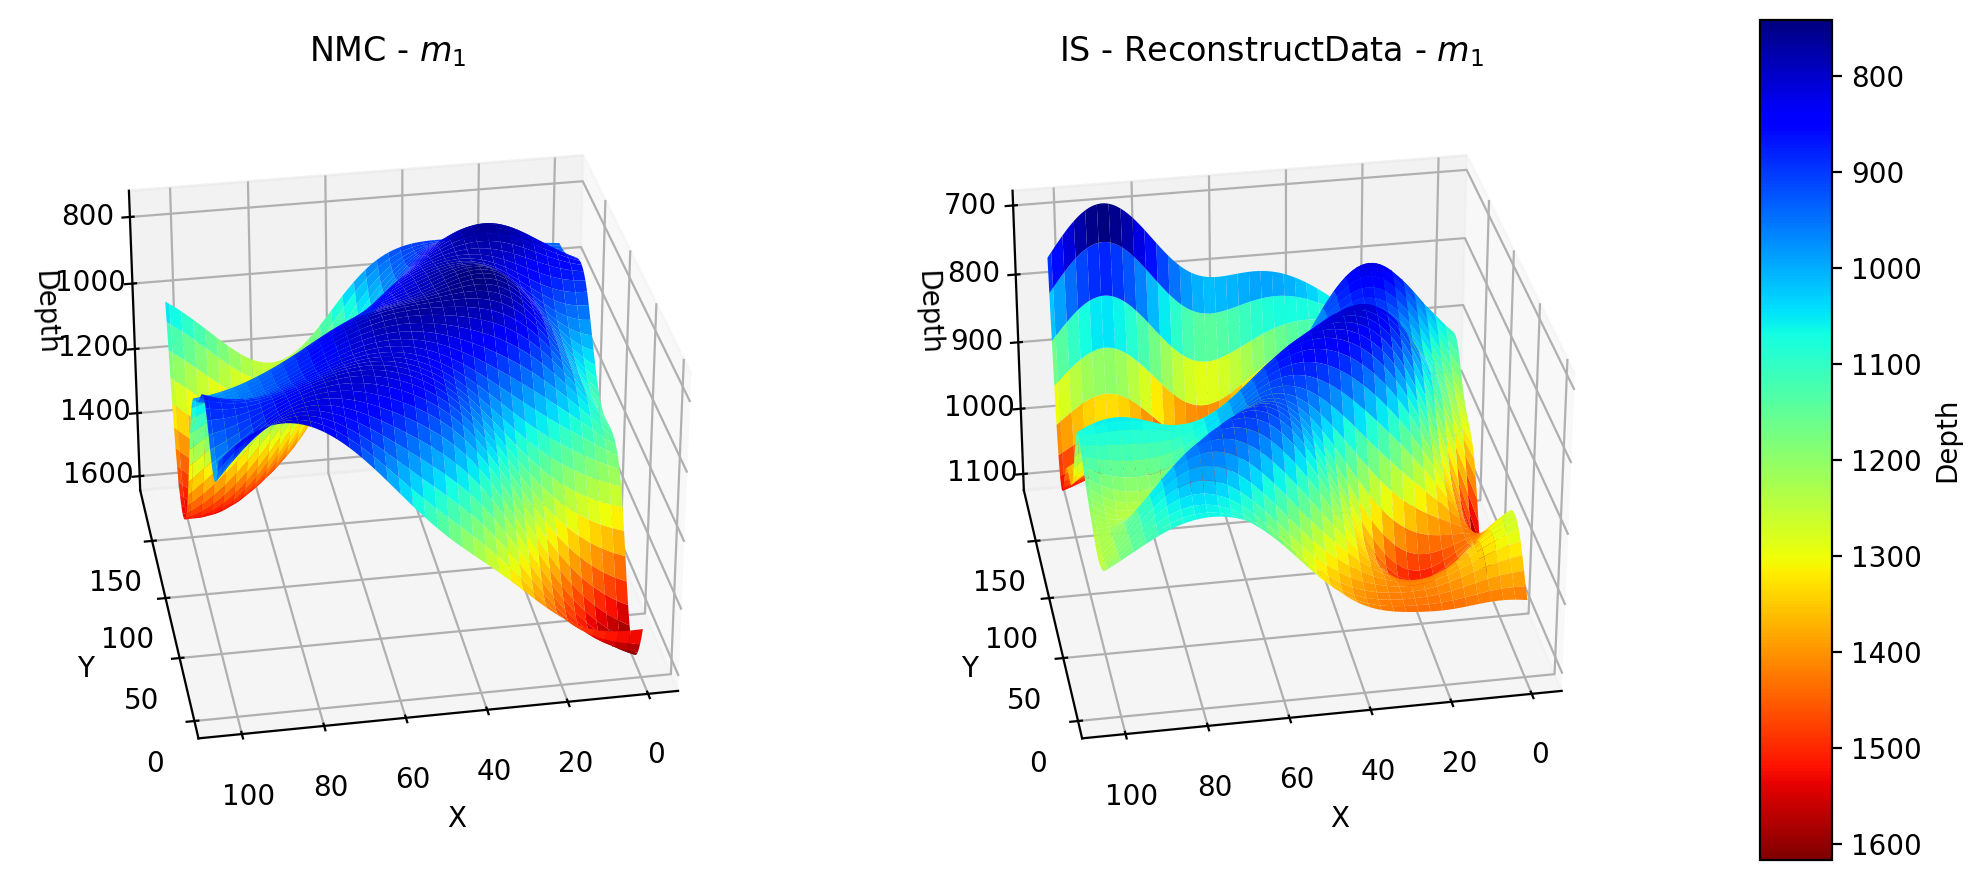

In [293]:
# Reshape the data
reconstructed_column = ReconstructData[:, fig_n].reshape(grid_shape)
m_1_column = m_1_ex[:, fig_n].reshape(grid_shape)

# Create a grid of x, y coordinates
x = np.arange(grid_shape[1])
y = np.arange(grid_shape[0])
X, Y = np.meshgrid(x, y)

# Create a figure with subplots and colorbar
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot the 'm_1' on the first subplot
surf1 = ax1.plot_surface(X, Y, m_1_column, cmap='jet')
ax1.set_title('NMC - $m_1$')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Depth')
ax1.view_init(elev=-150, azim=100) # Adjust the elevation (elev) and azimuth (azim) angles

# Plot the 'ReconstructData' on the first subplot
surf2 = ax2.plot_surface(X, Y, reconstructed_column, cmap='jet')
ax2.set_title('IS - ReconstructData - $m_1$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Depth')
ax2.view_init(elev=-150, azim=100)  # Adjust the elevation (elev) and azimuth (azim) angles

# Create a common colorbar
fig.subplots_adjust(right=0.8)  # Adjust the position of the subplots
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])  # Position of the colorbar
cbar = fig.colorbar(surf1, cax=cbar_ax)  # Use surf1 for the colorbar

# Set label for the colorbar
cbar.set_label('Depth')
# Invert the colorbar
cbar.ax.invert_yaxis()

# Save the plot with higher DPI
plt.savefig(OUTPUTS_FOLDER + '3d_m_1_reconstruction.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Posterior m_2 reconstruction
m_2_ex = m_2[:,:n_re_smpl] #example of prior phi
data_m_2 = np.transpose(m_2_ex)  # Assuming crop_tsurf is the input data
nextractpc = n_re_smpl - 1

# Perform PCA
pca = PCA(n_components=nextractpc)
pca.fit(data_m_2)
pcs =  pca.components_ # Transpose the data
score = m_2_score_upd.iloc[:, :nextractpc]  # Replace with the desired score, sliced to nextractpc columns

# Reconstruct the data
dataapprox = np.dot(score, pcs)
datamean = np.mean(data_m_2, axis=0)
datamean_reshaped = datamean.reshape(1, -1)  # Reshape datamean to (1, 19136)
datamean_broadcasted = np.tile(datamean_reshaped, (dataapprox.shape[0], 1))
ReconstructData = datamean_broadcasted + dataapprox
ReconstructData = ReconstructData.T

# Set negative values to 0
ReconstructData = np.clip(ReconstructData, 0.001, None)

# EXPORT to MATLAB
# Convert ReconstructData to double
m_2 = ReconstructData.astype(float)
# Create a dictionary to store the data
data_dict = {'m_2': m_2}
# Save the data as a MATLAB .mat file
savemat(OUTPUTS_FOLDER + 'm_2.mat', data_dict)

### **Summary and Transition**

**Completed scope:**  
This notebook implements **Steps 1–5.5** of the workflow, covering:

- Naïve Monte Carlo (NMC) baseline generation and Chebyshev confidence analysis.  
- Dimensionality reduction (PCA) and sensitivity screening (DGSA).  
- Construction of the alternative sampling distribution $g(\mathbf{m})$ using Multivariate Kernel Density Estimation (MKDE).  
- Resampling of sensitive PC scores from $g(\mathbf{m})$ and reconstruction of updated model variables $(m_1', m_2')$.  

These steps complete the **importance-sampling setup**, generating new realizations biased toward leakage-prone regions of the parameter space while preserving overall variability.

**Outcome:**  
The reconstructed $(m_1', m_2')$ ensembles form the input for the next stage, where their influence on leakage probability will be evaluated through weighted re-sampling.  
This enables comparison between the full Naïve Monte Carlo ensemble and the reduced Importance Sampling ensemble in terms of accuracy and computational efficiency.

**Next notebook:**  
➡️ Proceed to **`Script_after_prior_simulation_2025.ipynb`** to continue with **Step 6**.
